### 1. Import Libraries

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

#### 2. Check Directory Existence and List Contents

In [8]:
import os

partial_path = r"C:\Users\varma\OneDrive\Desktop\ML project\archive (2)\lgg-mri-segmentation"

if os.path.exists(partial_path):
    print("Partial path exists. Available directories:")
    print(os.listdir(partial_path))  
else:
    print("Partial path does not exist. Please verify.")


Partial path exists. Available directories:
['kaggle_3m']


#### 3. Change Current Working Directory

In [9]:
import os

directory_path = r"C:\Users\varma\OneDrive\Desktop\ML project\archive (2)\lgg-mri-segmentation\kaggle_3m"

os.chdir(directory_path)

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\varma\OneDrive\Desktop\ML project\archive (2)\lgg-mri-segmentation\kaggle_3m


#### 4. Load Dataset

In [10]:
brain_df = pd.read_csv('data_mask.csv')

In [11]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

#### 5. Display DataFrame Information

In [12]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [17]:
brain_df.head(5)

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [18]:
brain_df.tail(5)

patient_id  \
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0

#### 6. Access Specific Mask Path

In [14]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [15]:
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

#### 7. Count Unique Values in Mask Column

In [16]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

In [19]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

#### 8. Get Unique Mask Labels

In [20]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [22]:
!pip install plotly


   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
    --------------------------------------- 0.3/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/19.1 MB 1.3 MB/s eta 0:00:15
   - -------------------------------------- 0.8/19.1 MB 1.4 MB/s eta 0:00:14
   -- ------------------------------------- 1.0/19.1 MB 1.4 MB/s eta 0:00:13
   -- ------------------------------------- 1.3/19.1 MB 1.5 MB/s eta 0:00:13
   --- ------------------------------------ 1.6/19.1 MB 1.4 MB/s eta 0:00:13
   --- ------------------------------------ 1.8/19.1 MB 1.5 MB/s eta 0:00:12
   ---- ----------------------------------- 2.4/19.1 MB 1.5 MB/s eta 0:00:12
   ----- ---------------------------------- 2.6/19.1 MB 1.4 MB/s eta 0:00:12
   ----- ---------------------------------- 2.6/19.1 MB 1.4 MB/s eta 0:00:12
   ------ --------------------------------- 2.9/19.1 MB 1.3 MB/s eta 0:00:13
   ------ --------------------------------- 2.9/19.1 MB 1.3 MB/s eta 0:00:13
   ------- --

In [90]:
!pip install keras_preprocessing

#### 9. Visualize Mask Counts with a Bar Chart

Text(0, 0.5, 'Count')

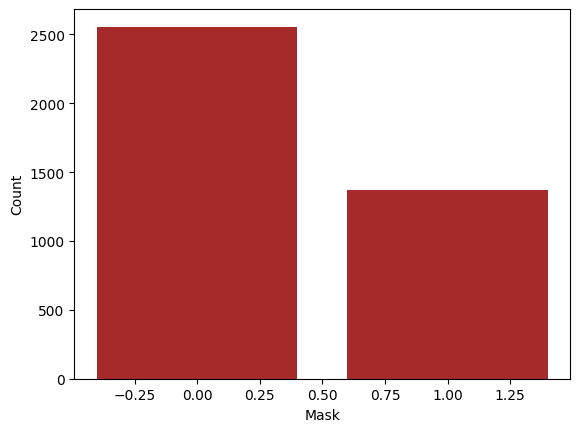

In [41]:
import matplotlib.pyplot as plt

counts = brain_df['mask'].value_counts()
plt.bar(counts.index, counts.values, color='brown')
plt.xlabel("Mask")
plt.ylabel("Count")




#### 10. Access All Mask Paths

In [42]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

#### 10. Access All Image Paths

In [43]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

#### 11. Display a Sample Image

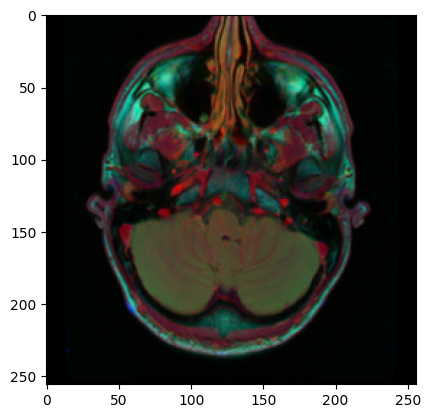

In [52]:
plt.imshow(cv2.imread(brain_df.image_path[669]))

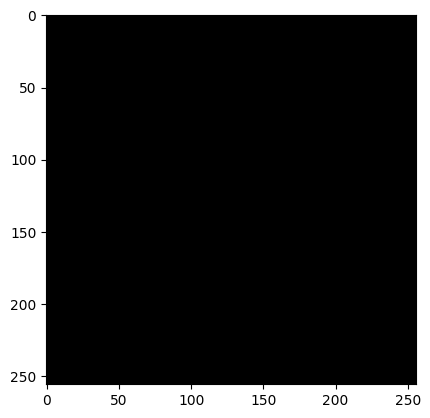

In [53]:
plt.imshow(cv2.imread(brain_df.mask_path[669]))

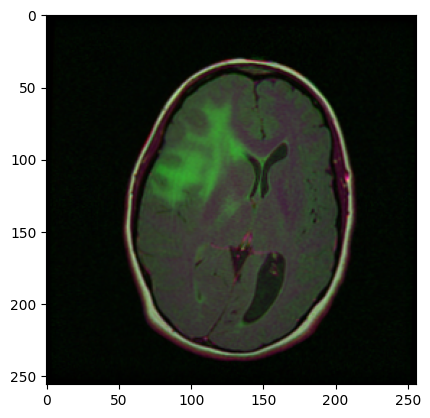

In [62]:
plt.imshow(cv2.imread(brain_df.image_path[2569]))

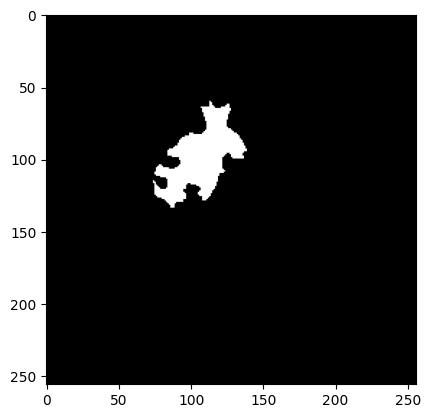

In [63]:
plt.imshow(cv2.imread(brain_df.mask_path[2569]))

#### 12. Get Maximum Pixel Value from a Mask Image

In [66]:
cv2.imread(brain_df.mask_path[2569]).max()

255

#### 13. Display Random Sample Images with Masks

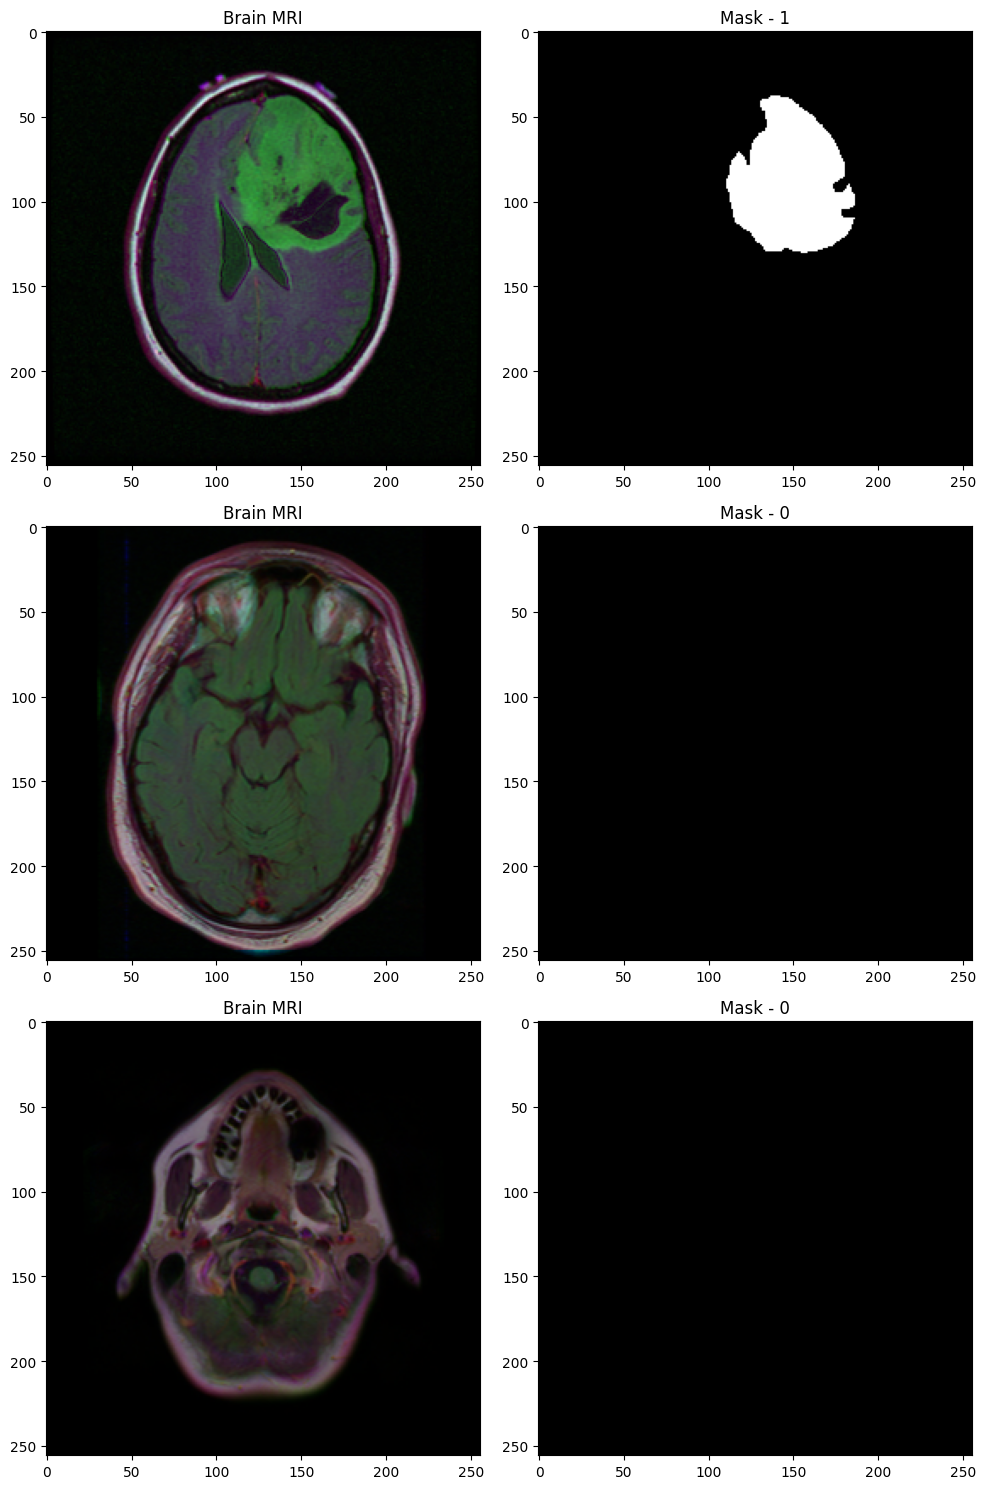

In [76]:
import random
fig, axs = plt.subplots(3,2, figsize=(10,15))
count = 0
for x in range(3):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) 
  count += 1
fig.tight_layout()



#### 14. Display Brain MRI Images with Overlaid Masks

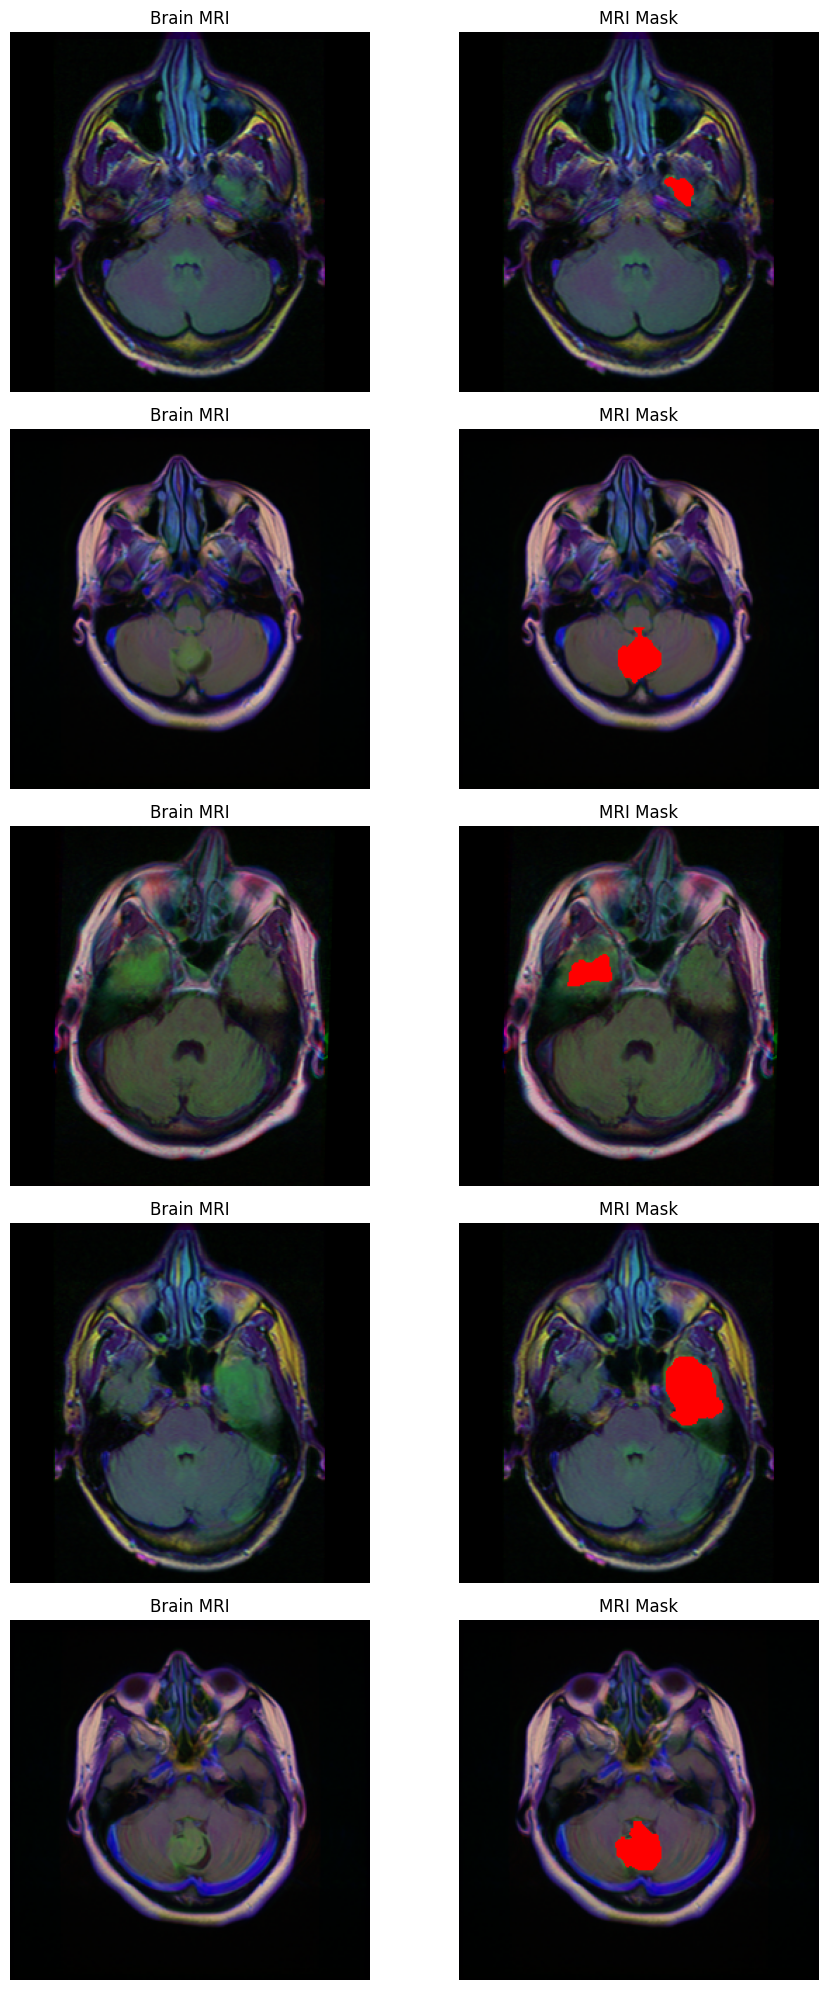

In [84]:
count = 0
fig, axs = plt.subplots(5, 2, figsize=(10, 20))  

for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and count < 5:
        
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        axs[count][0].axis('off')  
        mask = io.imread(brain_df.mask_path[i])  
        overlay_img = img.copy()  
        overlay_img[mask == 255] = (255, 0, 0)  
        axs[count][1].title.set_text("MRI Mask")
        axs[count][1].imshow(overlay_img)
        axs[count][1].axis('off')  

        count += 1

fig.tight_layout()
plt.show()

#### 15. Prepare Training Data by Dropping Unnecessary Columns

In [86]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

#### 16. Convert Mask Values to String

In [87]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [88]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


#### 17. Split Data into Training and Test Sets

In [89]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

#### 18. Initialize Image Data Generator 

In [91]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

#### 19. Create Training Data Generator from DataFrame

###### Data generators like ImageDataGenerator are used for real-time data augmentation and efficient memory management by loading images in batches. They preprocess images on-the-fly, improving model robustness while ensuring that large datasets fit within memory constraints.

##### 
Use of the generators
1. Real-time Data Augmentation
2. Memory Efficiency
3. Dynamic Data Processing
4. Ease of Training
5. Batch Processing

In [92]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.


#### 20. Create Validation Data Generator from DataFrame

In [93]:
valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 500 validated image filenames belonging to 2 classes.


#### 21. Create Test Data Generator from DataFrame

In [94]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 590 validated image filenames belonging to 2 classes.


#### 22. Initialize Base Model with ResNet50

In [95]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 77s 1us/step


#### 23. Display Summary of the Base Model

In [96]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [97]:
for layer in basemodel.layers:
  layers.trainable = False

#### 24. Build Custom Head for the Model

In [98]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [101]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

#### 25. Compile the Model

####
Adam (Adaptive Moment Estimation) is a popular optimization algorithm that combines the advantages of two other optimizers: AdaGrad and RMSProp. It adapts the learning rate for each parameter individually, which often leads to faster convergence and better performance in training deep learning models.

In [102]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

#### 26. Set Up Callbacks for Training

####
EarlyStopping:
Early stopping is used to prevent overfitting by monitoring the validation loss during training. If the validation loss does not improve for a specified number of epochs (patience), training stops, helping to retain the best model.


#### 
ModelCheckpoint:
This callback saves the models  weights at certain points during training (e.g., when validation loss improves). This ensures that the best-performing model can be restored later, preventing loss of progress due to potential overfitting or model degradation.

In [103]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)
     

#### 27. Compile the Model with Adam Optimizer and Learning Rate

In [106]:
from keras.optimizers import Adam
learning_rate = 0.001 
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


#### 28. Train the Model

In [107]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])
     

177/177 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.6589 
Epoch 1: val_loss improved from inf to 0.72858, saving model to classifier-resnet-weights.hdf5


C:\Users\varma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



177/177 [==============================] - 4567s 26s/step - loss: 0.8007 - accuracy: 0.6589 - val_loss: 0.7286 - val_accuracy: 0.3448


#### 29. Save Model Architecture to JSON File

In [108]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

#### 30. Construct the Model Head with Dense Layers

####
Dense layers are fully connected layers that learn complex representations of the input data, enabling the model to capture intricate patterns. They also introduce non-linearity and are crucial for mapping learned features to output classes during the final prediction.

In [109]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

#### 31. Load Model Architecture and Weights from Files

In [113]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

#### 32. Make Predictions on Test Data

In [114]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 187s 5s/step


In [115]:
test_predict.shape

(576, 2)

In [118]:
test_predict.dtype

dtype('float32')

In [119]:
test_predict.ndim

2

In [120]:
test_predict.size

1152

#### 33. View Predictions on Test Data

In [121]:
test_predict

array([[9.9999785e-01, 2.0928262e-06],
       [2.0253083e-05, 9.9997973e-01],
       [9.9986660e-01, 1.3343670e-04],
       ...,
       [5.3002161e-01, 4.6997839e-01],
       [9.9950075e-01, 4.9926637e-04],
       [9.9627835e-01, 3.7216397e-03]], dtype=float32)

In [122]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [123]:
predict

array(['0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1',
       '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0',
       '0', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1',
       '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1',
       '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1',
       '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1',
       '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1',
       '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1',
       '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0

In [124]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

#### 34. Calculate Accuracy 

In [125]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy
     

0.9878472222222222

#### 35. Plot Confusion Matrix

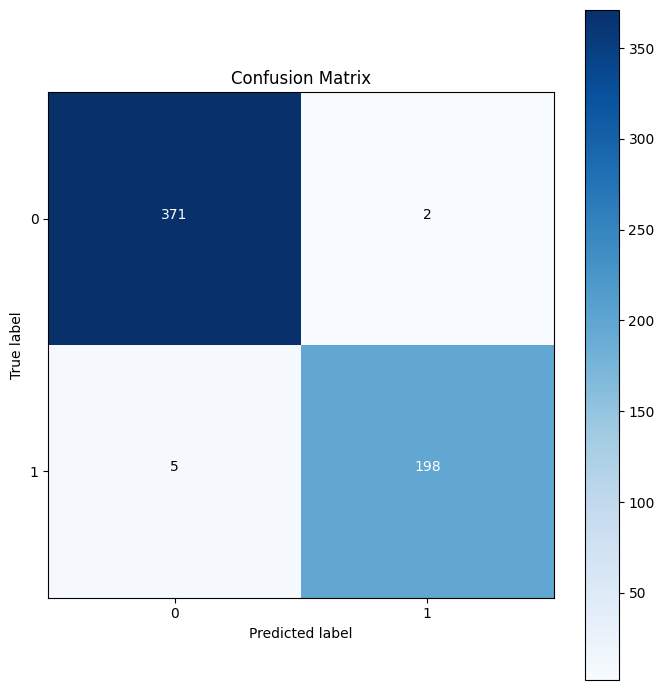

In [128]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)

plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(original)))  
plt.xticks(tick_marks, np.unique(original))
plt.yticks(tick_marks, np.unique(original))

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



#### 36. Visualize Confusion Matrix with Heatmap

<Axes: >

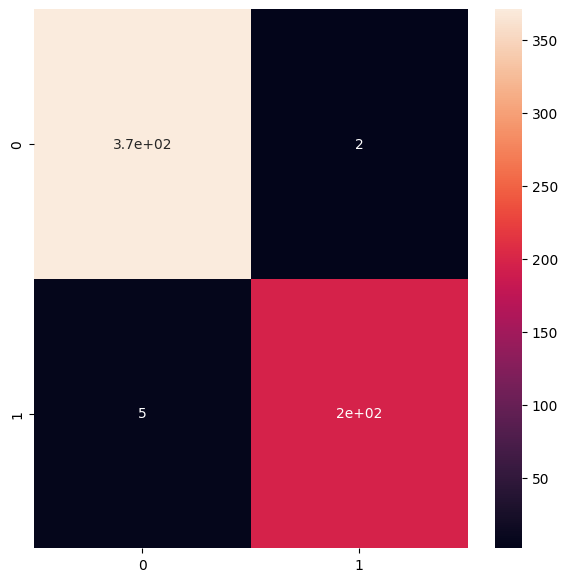

In [126]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
     

#### 37. Filter DataFrame for Brain Masks

In [155]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

#### 38. Split Data into Training, Validation, and Test Sets

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

#### 39. Extract Image and Mask Paths for Training and Validation

In [157]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [160]:
!pip install tensorflow


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.26.0 requires typing-extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.
python-pptx 1.0.2 requires typing-extensions>=4.9.0, but you have typing-extensions 4.5.0 which is incompatible.
torch 2.4.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.



  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2


#### 40. Create Image Generators for Training and Validation

In [162]:
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

#### 41.  Residual Block Function for Neural Network

In [163]:
def resblock(X, f):

  X_copy = X


  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)


  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)


  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X
     

#### 42.Upsampling and Concatenation Function

In [164]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

#### 43. Define U-Net Architecture for Segmentation

In [165]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [166]:
model_seg.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['batch_normalization[0]

In [167]:
from utilities import focal_tversky, tversky_loss, tversky

#### 44. Compile U-Net Model with Adam Optimizer and Custom Loss Function

#### 
In this code, the U-Net model for segmentation is compiled using the Adam optimizer with a specified learning rate and epsilon. The model uses custom loss functions, focal_tversky for loss calculation and tversky for evaluation metrics, which are particularly useful in scenarios involving class imbalance.

In [169]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [170]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [171]:
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

#### 46. Load U-Net Model Architecture and Weights

In [172]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

#### 47. Making Predictions with the U net

In [173]:
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 296ms/step


In [174]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2.tif   
1    TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13...   
2    TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23...   
3    TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_16...   
4    TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19...   
..                                                 ...   
585  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_43...   
586  TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_24...   
587  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_66...   
588  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_35...   
589  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1    [[[[8.547524e-07], [5.308356e-06], [5.876899e-...         1  
2                                              No mask         0  
3                                              No mask         0  
4    [[[[8.151043e-07], [3.5446217e-06], [1.0319338...         1  
..                                                 ...       ...  
585                                            No mask         0  
586  [[[[6.742223e-07], [2.3539812e-06], [4.5844135...         1  
587                                            No mask         0  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [175]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2.tif   
1  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13...   
2  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23...   
3  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_16...   
4  TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19...   

                                           mask_path mask  \
0  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2_...    0   
1  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13...    1   
2  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23...    0   
3  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_16...    0   
4  TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19...    1   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[8.547524e-07], [5.308356e-06], [5.876899e-...         1  
2                                            No mask         0  
3                                            No mask         0  
4  [[[[8.151043e-07], [3.5446217e-06], [1.0319338...         1

#### 48. Visualizing Predictions

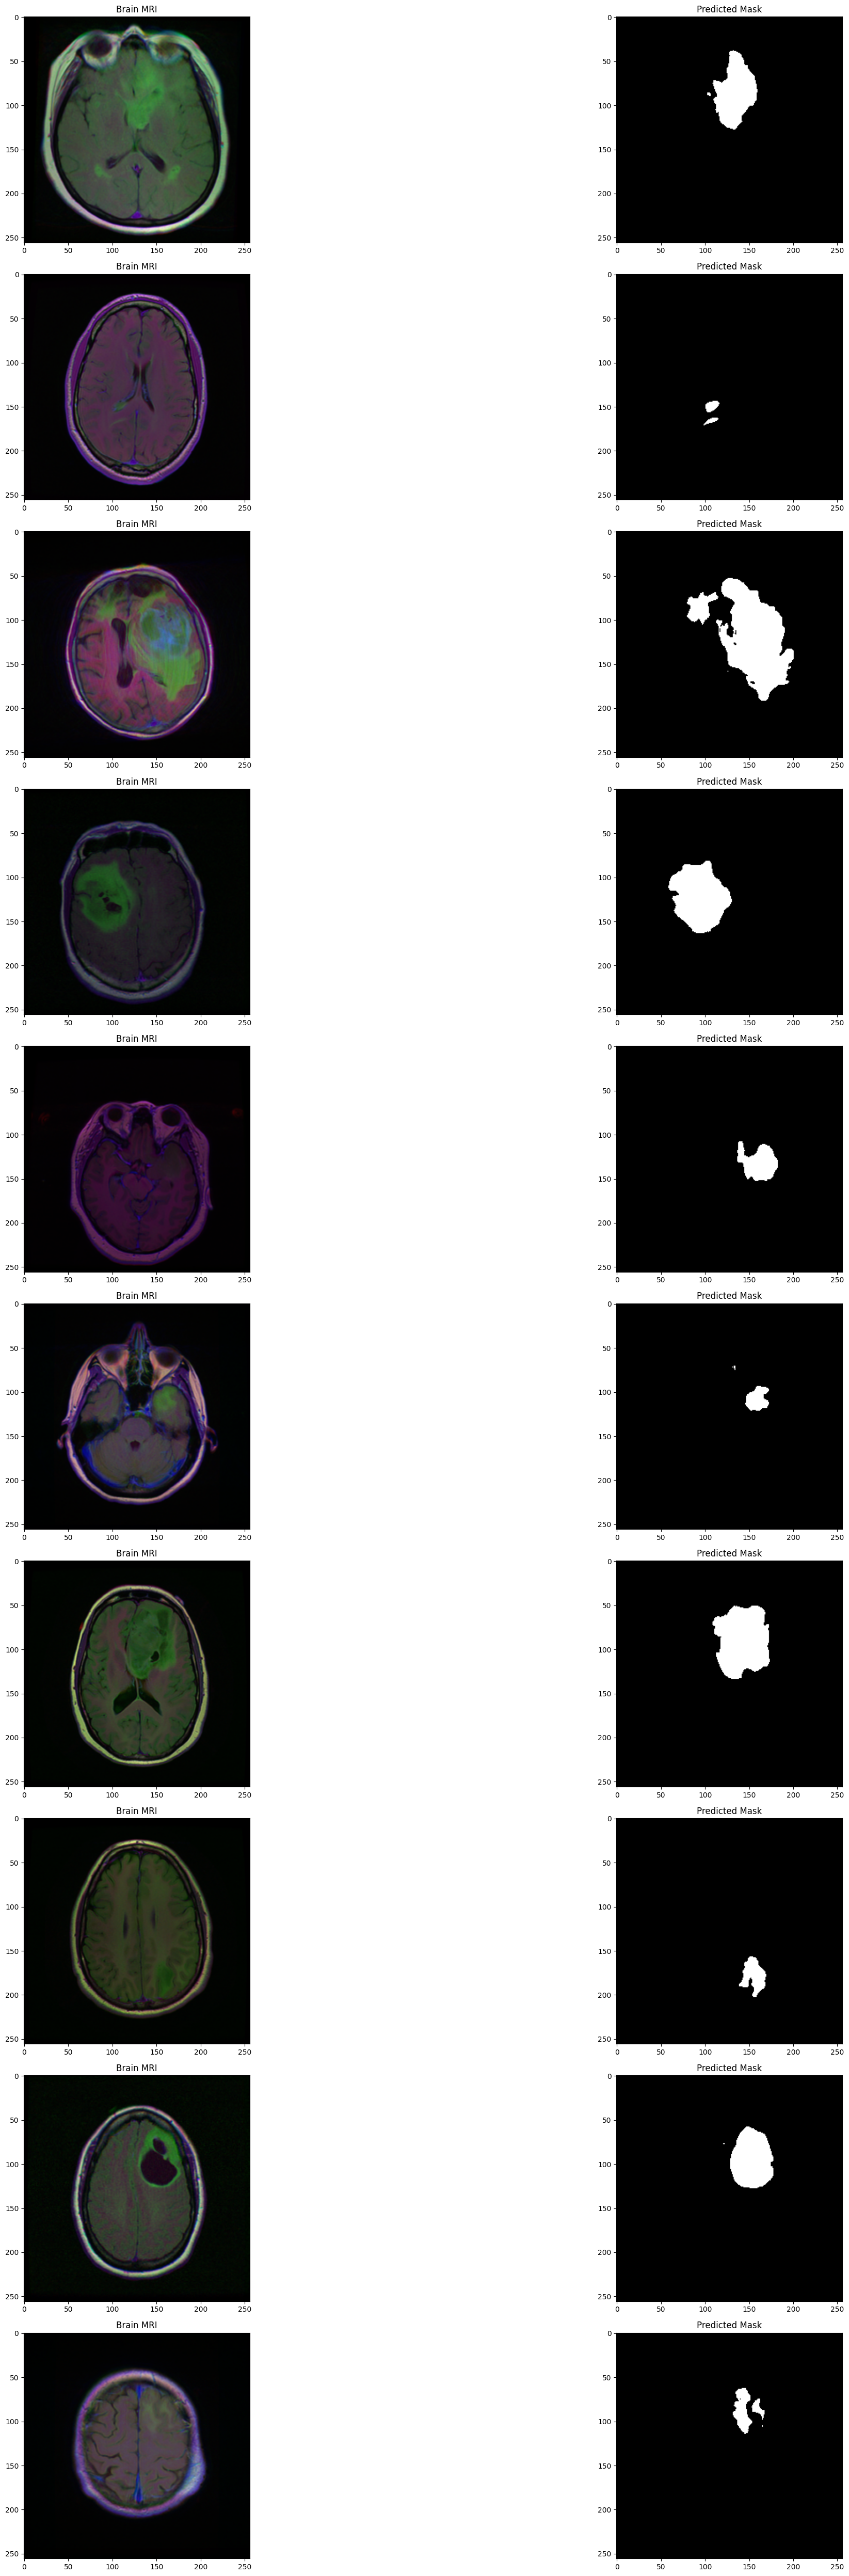

In [191]:
count = 0
fig, axs = plt.subplots(10, 2, figsize=(30, 50))  # 10 rows, 2 columns

for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
        
        img = io.imread(df_pred.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)  

        predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()

        predicted_mask_gray = (predicted_mask * 255).astype(np.uint8)  
        axs[count][1].title.set_text("Predicted Mask")  
        axs[count][1].imshow(predicted_mask_gray, cmap='gray')  

        count += 1

fig.tight_layout()
plt.show()


#### Visualizing Brain MRI Images and Masks

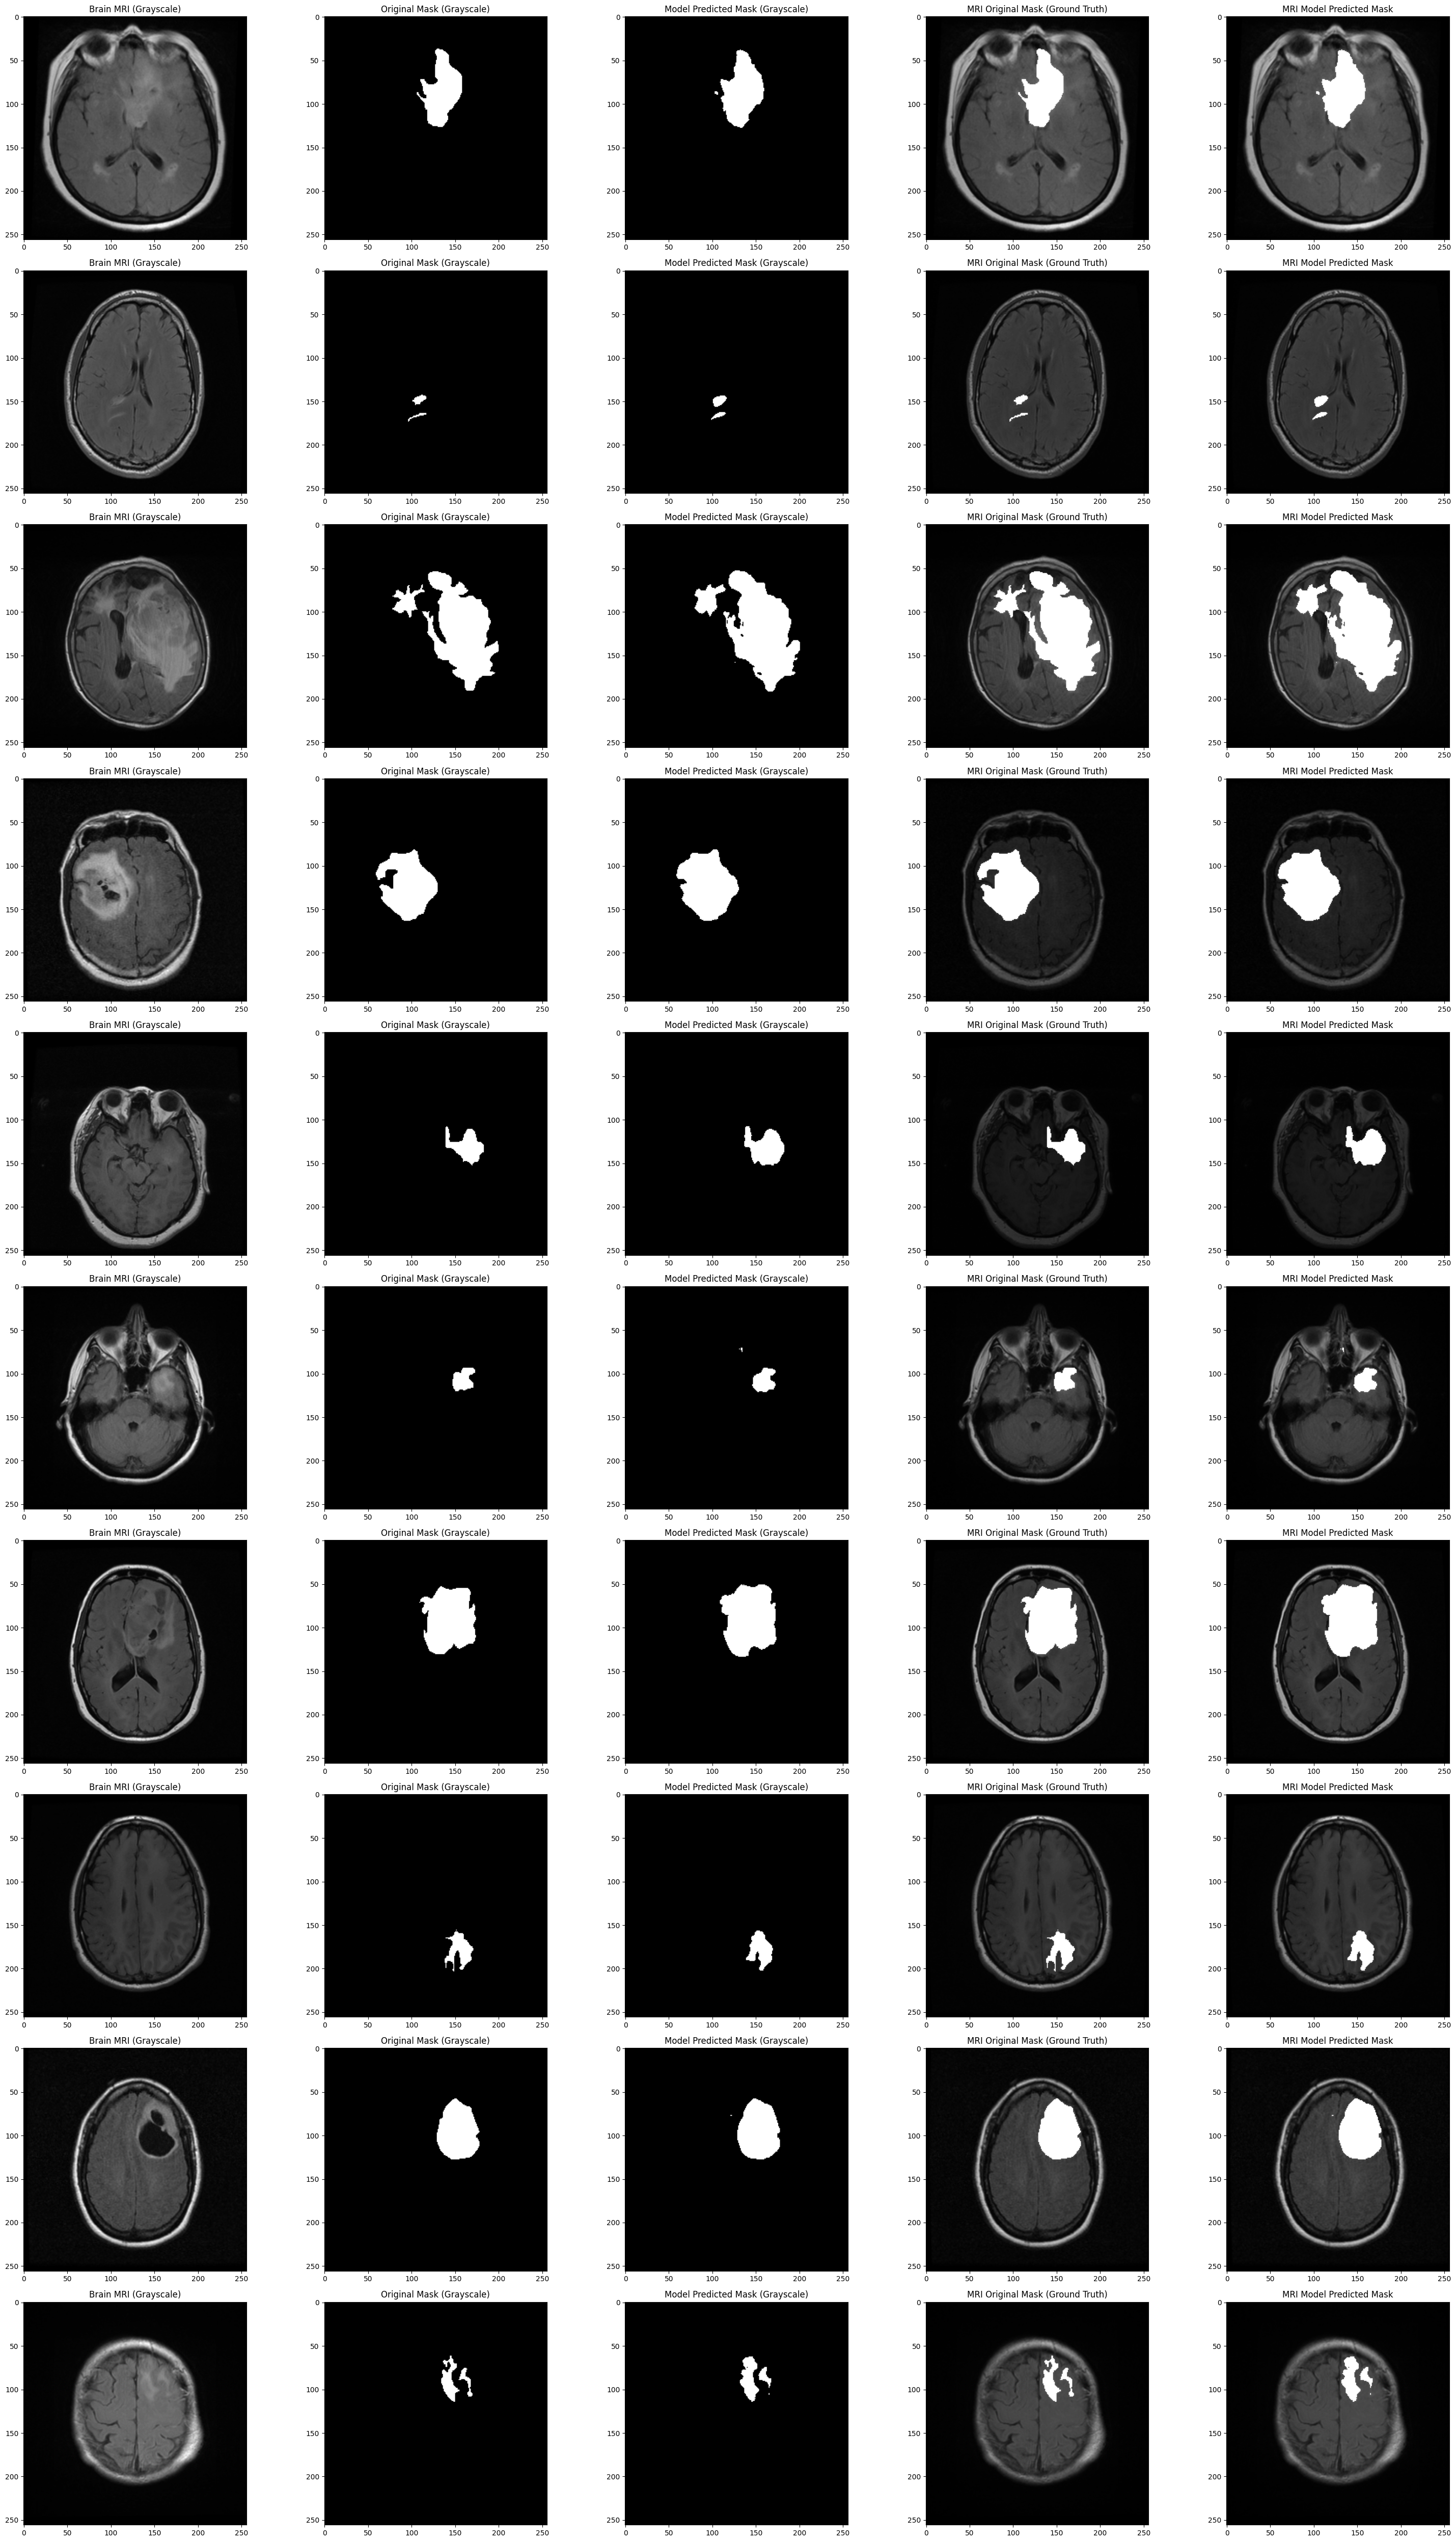

In [187]:
from skimage import io, color
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))  # 10 rows, 5 columns

for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
        
        img = io.imread(df_pred.image_path[i])
        img_gray = color.rgb2gray(img)  
        axs[count][0].title.set_text("Brain MRI (Grayscale)")
        axs[count][0].imshow(img_gray, cmap='gray') 

        # Obtain the mask for the image
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].title.set_text("Original Mask (Grayscale)")
        axs[count][1].imshow(mask, cmap='gray')  

        # Obtain the predicted mask for the image
        predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
        axs[count][2].title.set_text("Model Predicted Mask (Grayscale)")
        axs[count][2].imshow(predicted_mask, cmap='gray')  

        # Apply the original mask to the grayscale image
        img_with_original_mask = img_gray.copy() 
        img_with_original_mask[mask == 255] = 1  
        axs[count][3].title.set_text("MRI Original Mask (Ground Truth)")
        axs[count][3].imshow(img_with_original_mask, cmap='gray') 

        img_with_predicted_mask = img_gray.copy()  
        img_with_predicted_mask[predicted_mask == 1] = 1  
        axs[count][4].title.set_text("MRI Model Predicted Mask")
        axs[count][4].imshow(img_with_predicted_mask, cmap='gray')  

        count += 1

fig.tight_layout()
plt.show()